In [2]:
import numpy as np 
import scipy.stats as st 
from queue import *
import math
from distances import *
from statistics import mean 
import matplotlib.pyplot as plt

In [3]:

class Event: 
    def __init__( self, time ):
        self.time = time   
    def __lt__( self, other ):
        return self.time < other.time  
    def handle( self ):
        """updates the global simulation clock time to the class's current time attribute
        preconditions: none"""
        global simulationclock
        simulationclock = self.time
    
class NewRequest(Event, object): #An arrival occurs 
    def __init__( self, time):
        """creates a new object of class NewRequest and sets the class time attribute to the time argument
        Preconditions: time is the desired simulation clock time of the NewRequest"""
        super(NewRequest, self).__init__( time )
    def __lt__( self, other ):
        return self.time < other.time   
    def handle( self ):
   
        super(NewRequest, self).handle() # inherit operations in the function in the base class, simulation clock updated to the time when the arrival event occurs
        center = getBC()
        # request = Request(nextId, center, simulationclock, None )
        request = Request(center, simulationclock, None )
        # nextId += 1 
        eventlist.put( NewRequest( simulationclock + arrivaltime() ) )
        closest_mechanic_center, distance = closest_available_mechanic(request.center, bc_list)
        if closest_mechanic_center == None:
            requestQueue.append(request) 
        elif closest_mechanic_center == DispatchCenter: 
            DispatchCenter.num_mechs -= 1
            eventlist.put(mech_Arrives(simulationclock+(distance/60), request.center, request)) 
        else: 
            eventlist.put(mech_Arrives(simulationclock+(distance/60), request.center, request))
            closest_mechanic_center.free_mechanics -= 1
            closest_mechanic_center.number_of_mechanics -=1


class mech_Arrives(Event, object): 
    def __init__(self, time, business_center, request): 
        super(mech_Arrives, self).__init__(time)
        self.business_center = business_center
        self.request = request
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        """update the global simulation time to the event time, schedule the end of the diagnosis for 
        diagnosis_time later, and increase the number of busy mechanics at the business center by 1"""
        super(mech_Arrives, self).handle()
        self.request.time_responded = (simulationclock - self.request.timeEntered)*60
        time_to_respond_avg.append(self.request.time_responded) if simulationclock>t else None
        diag_time = diagnosis_Time(self.business_center)
        self.business_center.number_of_mechanics += 1 
        eventlist.put(diag_ends(simulationclock+ diag_time, self.business_center))
        
        

class diag_ends(Event, object):
    def __init__(self, time, business_center):
        super(diag_ends, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        super(diag_ends, self).handle()
        BC_prob = np.random.uniform(0,1)
        options = ['repair', 'replace']
        #outcome_probabilities = np.array([0.8195, 0.1805])
        outcome = np.random.choice(options, 1, p = outcome_probabilities)[0]   
        if outcome == 'repair':
            eventlist.put(repair_start(simulationclock, self.business_center))
        else:
            eventlist.put(call_van(simulationclock, self.business_center))

class repair_start(Event, object): 
    def __init__(self, time, business_center): 
        super(repair_start, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self): 
        super().handle()
        repair_time = st.beta.rvs(2.6158007964976218, 7.460626334186162, -0.0077049330279426054, 1.557915557823419, size=1)[0]
        #repair_time = st.beta.rvs(3, 8, -0.0077049330279426054, 1.557915557823419, size=1)[0]
        #repair_time = st.rayleigh.rvs(0.0013399745442049282, 0.31486846900358867)
        eventlist.put(repair_end(simulationclock+ repair_time, self.business_center))


class repair_end(Event, object):
    def __init__(self, time, business_center): 
        super(repair_end, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self): 
        super(repair_end, self).handle()
        eventlist.put(mechanic_leaves_business_center(simulationclock, self.business_center))           

            
class mech_goes_to_dispatch(Event,object): 
    def __init__(self, time):
        super(mech_goes_to_dispatch,self).__init__(time)
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        super(mech_goes_to_dispatch,self).handle()
        DispatchCenter.num_mechs += 1
        if len(requestQueue>0):
            req = requestQueue[0]
            requestQueue.remove(req)
            dist = distances.at['Dis', req.center.name]
            travel_time = dist/60
            eventlist.put(mech_Arrives(simulationclock+travel_time, req.center, req))
            DispatchCenter.num_mechs -= 1
            

        


####### REPLAACEMENT STARTS HERE
class call_van(Event,object):
    def __init__(self, time, business_center):
        super().__init__( time )
        self.business_center = business_center
    def handle(self):
        super(call_van,self).handle()
        copier_request =  Request(self.business_center, simulationclock, None)
        if DispatchCenter.available_vans > 0: 
            DispatchCenter.available_vans -= 1 
            dist = distances.at['Dis', copier_request.center.name]
            travel_time = dist/60
            eventlist.put(van_arrives_at_bc(simulationclock+travel_time, self.business_center, copier_request))           
        else:
            copierQueue.put(copier_request)
        eventlist.put(mechanic_leaves_business_center(simulationclock, self.business_center))           


class mechanic_leaves_business_center(Event, object):
    def __init__(self, time, business_center):
        super().__init__( time )
        self.business_center = business_center
    def handle(self):
        if len(requestQueue)==0:
            self.business_center.free_mechanics += 1
        else: 
            req = closest_request(self.business_center)
            dist = distances.at[req.center.name, self.business_center.name]
            travel_time = dist/60
            eventlist.put(mech_Arrives(simulationclock+travel_time, req.center, req))
            self.business_center.number_of_mechanics -= 1 

            
     
                
class van_arrives_at_bc(Event, object):
    def __init__(self, time, business_center, copier_request ):
        super().__init__( time )
        self.business_center = business_center
        self.copier_request = copier_request
    def handle(self):
        super(van_arrives_at_bc, self).handle()
        eventlist.put(van_returns_to_dispatch(simulationclock+swaptime_customer(), self.business_center, self.copier_request))
        


class van_returns_to_dispatch(Event, object):
    def __init__(self, time, business_center, copier_request):
        super().__init__(time)
        self.business_center = business_center
        self.copier_request = copier_request
    def handle(self):
        super(van_returns_to_dispatch, self).handle()
        self.copier_request.time_responded = (simulationclock - self.copier_request.timeEntered)*60
        copier_req_times.append(self.copier_request.time_responded) if simulationclock>t else None
        dist = distances.at['Dis', self.business_center.name]
        travel_time = dist/60 
        eventlist.put(van_swaps_copiers(simulationclock+travel_time))  

                      
class van_swaps_copiers(Event, object):
    def __init__(self, time):
        super().__init__(time)
    def handle(self):
        super(van_swaps_copiers, self).handle()
        eventlist.put(vans_finishes_swap(simulationclock + swaptime_dispatch()))
            
class vans_finishes_swap(Event, object):
    def __init__(self, time):
        super().__init__(time)
    def handle(self):
        super(vans_finishes_swap , self).handle()
        if copierQueue.empty():
            DispatchCenter.available_vans += 1
        else:
            cop_req = copierQueue.get()
            dist = distances.at['Dis', cop_req.center.name]
            travel_time = dist/60
            eventlist.put(van_arrives_at_bc(simulationclock+travel_time, cop_req.center, cop_req))
            

    

class Request(object): 
    def __init__( self, center, timeEntered, time_responded=None ):
        self.center = center
        # self.id = id      
        self.timeEntered = timeEntered
        self.time_responded = time_responded

def arrivaltime(): #Comes from input analysis question 6  
    global arrivalrate
    time_of_day = simulationclock%24
    if time_of_day < 22 and time_of_day >3: 
        arrivalrate = (-0.067*(time_of_day**2)) + 1.581*(time_of_day) - 1.289 
    else: 
        arrivalrate = 1.137 
        
    return np.random.exponential( 1 / arrivalrate )

def swaptime_dispatch(): #Service time to swap at the dispatch center, keeping everything in hours 
    return np.random.triangular(left=10/60, mode=15/60, right=25/60)

def swaptime_customer(): #Service time to swap at customer loctation 
    return np.random.triangular(left=20/60, mode=30/60, right = 1)
        
def diagnosis_Time(bc):
    if bc.name in ['BC_2', 'BC_3', 'BC_9']:
        return 1/60*np.random.normal(22.15, 5.34)   
    else:
        return 1/60*np.random.normal(16.13, 2.89)


def closest_available_mechanic(business_center, bc_list):
    available_mechanic_centers = []
    for x in bc_list:
        if x.free_mechanics > 0:
            available_mechanic_centers.append(x)
    if len(available_mechanic_centers)==0 and DispatchCenter.num_mechs ==0:
        return None, None
        

    if len(available_mechanic_centers)==0:
        if DispatchCenter.num_mechs > 0:
            disp_dist = distances.at['Dis', business_center.name]
            return DispatchCenter, disp_dist

        
    
    min_dist_center = available_mechanic_centers[0]
    min_dist = distances.at[min_dist_center.name, business_center.name]

    for y in available_mechanic_centers:
        dist = distances.at[y.name, business_center.name]
        if dist < min_dist:
            min_dist = dist
            min_dist_center = y
    if DispatchCenter.num_mechs != 0:
        disp_dist = distances.at['Dis', business_center.name]
        if disp_dist < min_dist:
            min_dist = disp_dist
            min_dist_center = DispatchCenter
  
    return min_dist_center, min_dist


def closest_request(BC):
    closest_req=requestQueue[0]
    closest_dist=distances.at[BC.name, closest_req.center.name]
    for req in requestQueue:
        if distances.at[BC.name, req.center.name] < closest_dist:
            closest_dist=distances.at[BC.name, req.center.name]
            closest_req=req
    requestQueue.remove(closest_req)
    return closest_req



    

In [4]:
class business_center(object):
    def __init__( self, name, coordinates, number_of_mechanics=0, number_of_vans=0, free_mechanics=0):
        self.name=name
        self.coordinates = coordinates
        self.number_of_mechanics = number_of_mechanics
        self.number_of_vans = number_of_vans
        self.free_mechanics = free_mechanics

In [5]:
class van(object):
    def __init__( self, busy=False, current_location=0, broken=False):
        self.busy = busy
        self.current_location = current_location 
        self.broken = broken

In [6]:
class dispatch(object):
    def __init__(self, coordinates, available_vans, num_mechs):
        self.coordinates = coordinates
        self.available_vans = available_vans
        self.num_mechs = num_mechs


In [7]:
class mechanic(object):
    def __init__(self, busy=False, current_location=0):
        self.busy = busy
        self.current_location= current_location


In [8]:
bc_coords = [[6,10],[4,8],[4,6],[1,6],[1,7],[9,3],[11,3],[9,2],[9,1],[11,1]]
bc_names = ['BC_1', 'BC_2', 'BC_3', 'BC_4', 'BC_5', 'BC_6', 'BC_7', 'BC_8', 'BC_9', 'BC_10']

# bc_list = []
# for i in range(len(bc_coords)):
#     bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
def getBC():
    BC_prob = np.random.uniform(0,1)
    probabilities = np.array([0.039509, 0.082089, 0.107916, 0.135418, 0.118386, 
                              0.055005, 0.123830, 0.057937, 0.137512, 0.142398])
    return np.random.choice(bc_list, 1, p = probabilities)[0]

In [ ]:

# mec_avgs=[]
# van_avgs=[]
# t=100
# T= 200
# B=100
# for i in range(B):
#     simulationclock = 0
#     requestQueue = []
#     copierQueue = Queue()
#     avail_vans = 3
#     num_mechs = 7
#     DispatchCenter = dispatch([5,2], avail_vans, num_mechs)
#     eventlist = PriorityQueue()
#     bc_list = []
#     for i in range(len(bc_coords)):
#         bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
#     a = NewRequest(0)
#     eventlist.put( a )
#     time_to_respond_avg = []
#     copier_req_times = []
    
#     while simulationclock < T:
#         e = eventlist.get()
#         e.handle()

#     mec_avgs.append(np.mean(np.array(time_to_respond_avg)))
#     van_avgs.append(np.mean(np.array(copier_req_times)))
    
        
        



In [ ]:
print("Mech Average:", mean(mec_avgs))
print("Van Average:", mean(van_avgs))



In [ ]:
# #mean and standard errors of the estimates
# mec_avgs_std=[]
# mec_se_std=[]
# van_avgs_std=[]
# van_se_std=[]
# t=0
# T=100
# B=50
# mu1=16.13
# mu2=22.15
# std1=2.89
# std2=5.34
# ##Vary the standard deviation of diagnosis time
# mu_adjusts=np.linspace(start=-5, stop=5, num=20)
# for j in mu_adjusts:
#     #copy in function that we want to look at
#     def diagnosis_Time(bc):
#         if bc.name in ['BC_2', 'BC_3', 'BC_9']:
#             return 1/60*np.random.normal(mu1+j, std1)
#         else: 
#             return 1/60*np.random.normal(mu2+j, std2)
#     mec_avgs=[]
#     van_avgs=[]
#     for i in range(B):
#         #initialize simulation
#         simulationclock = 0
#         requestQueue = []
#         copierQueue = Queue()
#         avail_vans = 3
#         num_mechs = 7
#         DispatchCenter = dispatch([5,2], avail_vans, num_mechs)
#         eventlist = PriorityQueue()
#         bc_list = []
#         for i in range(len(bc_coords)): 
#             bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
#         a = NewRequest(0)
#         eventlist.put( a )
#         time_to_respond_avg = []
#         copier_req_times = []
#         #run simulation
#         while simulationclock < T:
#             e = eventlist.get()
#             e.handle()
#         #record the averages
#         mec_avgs.append(np.mean(np.array(time_to_respond_avg)))
#         van_avgs.append(np.mean(np.array(copier_req_times)))
    
#     #keep track of mean and se
#     mec_avgs_muDi.append(np.mean(np.array(mec_avgs)))
#     mec_se_muDi.append(np.std(np.array(mec_avgs))/np.sqrt(B))
#     van_avgs_muDi.append(np.mean(np.array(van_avgs)))
#     van_se_muDi.append(np.std(np.array(vanm_avgs))/np.sqrt(B))

In [9]:
#mean and standard errors of the estimates
mec_avgs_p=[]
mec_se_p=[]
van_avgs_p=[]
van_se_p=[]
t=150
T=300
B=50
outcome_probabilities = np.array([0.8195, 0.1805])
p=.8195
##Vary the standard deviation of diagnosis time
p_adjusts=np.linspace(start=0, stop=1, num=101)
for j in p_adjusts:
    #copy in function that we want to look at
    outcome_probabilities = np.array([j, 1-j])
    mec_avgs=[]
    van_avgs=[]
    for i in range(B):
        #initialize simulation
        simulationclock = 0
        requestQueue = []
        copierQueue = Queue()
        avail_vans = 3
        num_mechs = 7
        DispatchCenter = dispatch([5,2], avail_vans, num_mechs)
        eventlist = PriorityQueue()
        bc_list = []
        for i in range(len(bc_coords)): 
            bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
        a = NewRequest(0)
        eventlist.put( a )
        time_to_respond_avg = []
        copier_req_times = []
        #run simulation
        while simulationclock < T:
            e = eventlist.get()
            e.handle()
        #record the averages
        mec_avgs.append(np.mean(np.array(time_to_respond_avg)))
        van_avgs.append(np.mean(np.array(copier_req_times)))
    
    #keep track of mean and se
    mec_avgs_p.append(np.mean(np.array(mec_avgs)))
    mec_se_p.append(np.std(np.array(mec_avgs))/np.sqrt(B))
    van_avgs_p.append(np.mean(np.array(van_avgs)))
    van_se_p.append(np.std(np.array(van_avgs))/np.sqrt(B))

C:\Users\ebeli\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ebeli\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


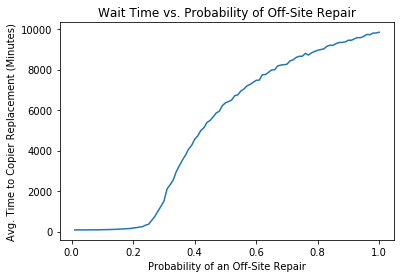

In [10]:
plt.plot(1-p_adjusts, van_avgs_p)
plt.xlabel('Probability of an Off-Site Repair')
plt.ylabel('Avg. Time to Copier Replacement (Minutes)')
plt.title('Wait Time vs. Probability of Off-Site Repair')
plt.show()

In [13]:
pd.DataFrame([1-p_adjusts,van_avgs_p]).transpose()[60:85]

,0,1
60,0.40,4561.145066
61,0.39,4255.201785
62,0.38,4069.115336
63,0.37,3772.230603
64,0.36,3531.027288
65,0.35,3249.005895
66,0.34,2956.663134
67,0.33,2540.476934
68,0.32,2313.215064
69,0.31,2094.229314
